In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import os
print(os.listdir("../input"))
seed=5
# Any results you write to the current directory are saved as output.

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


In [2]:
train_identity=pd.read_csv('../input/train_identity.csv')
# test_identity=pd.read_csv('../input/test_identity.csv')
train_transaction=pd.read_csv('../input/train_transaction.csv')
# test_transaction=pd.read_csv('../input/test_transaction.csv')

In [3]:
train=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
# test=pd.merge(test_transaction,test_identity,how='left',on='TransactionID')

In [4]:
del train_identity,train_transaction

In [5]:
target=train['isFraud']
train=train.drop(['isFraud','TransactionID'],axis=1)
# test=test.drop('TransactionID',axis=1)

In [6]:
from sklearn.model_selection import train_test_split

train,val,target,val_y=train_test_split(train,target,test_size=0.5,random_state=5,stratify=target)

In [7]:
del val,val_y

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295270 entries, 380295 to 42481
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 975.4+ MB


In [9]:
train=train.fillna(-999)
# test=test.fillna(-999)

In [10]:
from sklearn.preprocessing import LabelEncoder

cat_cols=[col for col in train.columns if train[col].dtype=='object']
for col in cat_cols:
    le=LabelEncoder()
    le.fit(list(train[col].values))
    train[col]=le.transform(list(train[col].values))
#     test[col]=le.transform(list(test[col].values))

In [11]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [12]:
train=reduce_mem_usage(train)
# test=reduce_mem_usage(test)

Memory usage of dataframe is 975.43 MB
Memory usage after optimization is: 262.72 MB
Decreased by 73.1%


In [13]:
def get_feature_importance(data,target,shuffle=False):
    y=target.copy()
    if shuffle:
        y=target.copy().sample(frac=1).reset_index(drop=True)
    
    xgb_params=dict(n_estimators=1000,
                verbosity=0,
                tree_method='gpu_hist',
               colsample_bytree=0.8,
               subsample=0.8,
               learning_rate=0.05,
               max_depth=5)
    
    clf=XGBClassifier(**xgb_params)
    clf.fit(train,y)
    
    feat_imp=pd.DataFrame()
    feat_imp['features']=train.columns
    feat_imp['importances']=clf.feature_importances_
    feat_imp['train_score']=roc_auc_score(y,clf.predict(train))
    del clf
    
    return feat_imp

In [14]:
np.random.seed(5)
actual_feat_imp=get_feature_importance(train,target,shuffle=False)

In [15]:
import time


null_feat_imps=pd.DataFrame()
start=time.time()
for i in range(50):
    start1=time.time()
    null_imp=get_feature_importance(train,target,shuffle=True)
    null_imp['round']=i+1
    null_feat_imps=pd.concat([null_feat_imps,null_imp],axis=0)
    del null_imp
    end1=time.time()
    epoch_time=(end1-start1)/60
    print(f'Round {i+1} completed in {epoch_time} mins')
    print('-'*100)

    
end=time.time()
total_time=(end-start)/60
print(f'Total time taken : {total_time} mins')

Round 1 completed in 0.5349635084470113 mins
----------------------------------------------------------------------------------------------------
Round 2 completed in 0.523067831993103 mins
----------------------------------------------------------------------------------------------------
Round 3 completed in 0.5322718580563863 mins
----------------------------------------------------------------------------------------------------
Round 4 completed in 0.5265001138051351 mins
----------------------------------------------------------------------------------------------------
Round 5 completed in 0.5259377280871074 mins
----------------------------------------------------------------------------------------------------
Round 6 completed in 0.5224870800971985 mins
----------------------------------------------------------------------------------------------------
Round 7 completed in 0.5248481353123983 mins
--------------------------------------------------------------------------------

In [16]:
def show_null_actual(feature):
    plt.figure(figsize=(10,5))
    a=plt.hist(null_feat_imps[null_feat_imps['features']==feature]['importances'],label='Null Importance')
    plt.vlines(x=actual_feat_imp[actual_feat_imp['features']==feature]['importances'],ymin=0,ymax=np.max(a[0]),color='r',linewidth=10,label='Real Target')
    plt.legend(loc='best')
    plt.title(f'Acutal Importance vs Null Importance of {feature}')
    plt.show()

In [17]:
actual_feat_imp.to_csv('Actual_imp.csv',index=False)
null_feat_imps.to_csv('Null_imp.csv',index=False)

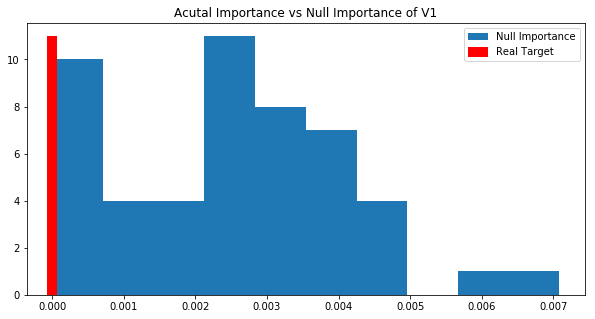

In [18]:
show_null_actual('V1')

In [19]:
feature_scores=[]

for feature in train.columns:
    null_imp=null_feat_imps[null_feat_imps['features']==feature]['importances'].values
    actual_imp=actual_feat_imp[actual_feat_imp['features']==feature]['importances'].values
    score=np.log((1e-10 + actual_imp/(1+np.percentile(null_imp,75))))[0]
    feature_scores.append((feature,score))

Text(0.5, 1.0, 'Scores of all features')

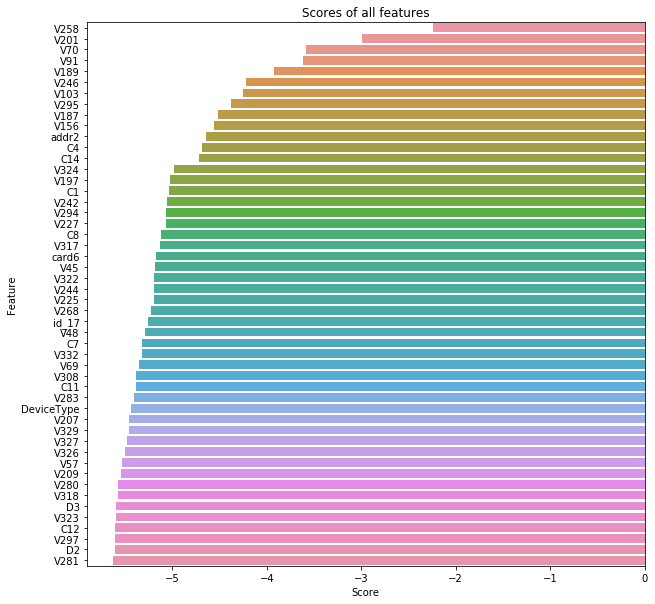

In [20]:
feature_score_df=pd.DataFrame(feature_scores,columns=['Feature','Score']).sort_values('Score',ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,10))
sns.barplot(x='Score',y='Feature',data=feature_score_df.iloc[:50,:])
plt.title('Scores of all features')

In [21]:
correlation_scores=[]

for feature in train.columns:
    null_imp=null_feat_imps[null_feat_imps['features']==feature]['importances'].values
    actual_imp=actual_feat_imp[actual_feat_imp['features']==feature]['importances'].values
    corr_score=100*(null_imp < actual_imp).sum()/null_imp.size
    correlation_scores.append((feature,corr_score))

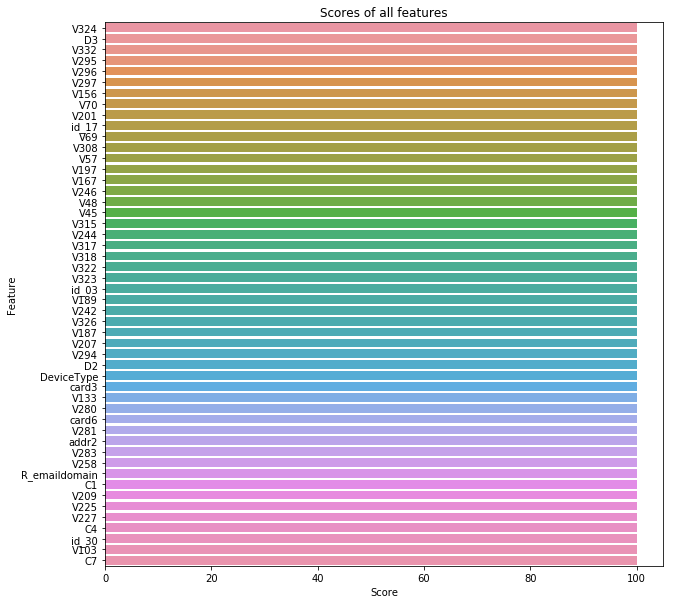

In [22]:
correlation_df=pd.DataFrame(correlation_scores,columns=['Feature','Score']).sort_values('Score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,10))
sns.barplot(x='Score',y='Feature',data=correlation_df.iloc[:50,:])
plt.title('Scores of all features')
plt.show()

In [23]:
def get_selection_score(data=train,target=target):
    xgb_params=dict(
                    verbosity=0,
                    tree_method='gpu_hist',
                    colsample_bytree=0.8,
               subsample=0.8,
               learning_rate=0.05,
               max_depth=5,
                   objective='binary:logistic',
                   metric='auc')
    
    train_d=xgb.DMatrix(data.values,label=target.values)
    result=xgb.cv(xgb_params,train_d,num_boost_round=1000,nfold=3,stratified=True,shuffle=True,early_stopping_rounds=50,verbose_eval=0,
                 seed=5)
    
    return result['auc_mean'][-1], result['auc_stdv'][-1]

In [24]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    print('Result for threshold ',threshold)
    worthy_features=[feature for feature in correlation_df['Feature'].values if correlation_df.loc[correlation_df['Feature']==feature,'Score'].values>=threshold]
    score=get_selection_score(train[worthy_features],target)
    print('AUC Mean :',score[0])
    print('AUC Std:',score[1])
    del score

Result for threshold  0


KeyError: 'auc_mean'